In [ ]:
# Rental Yield Prediction - Minimum Viable Product (MVP)
# AOP with AI Project - WizVision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import warnings
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# For reproducibility
np.random.seed(42)


## 1. Introduction

"""
This notebook focuses on building a Rental Yield Prediction model for HDB properties in Singapore.

Rental Yield is calculated as: (Annual Rental Income / Property Value) × 100%

Our approach:
1. First, predict property prices using historical resale data
2. Then, estimate rental income based on property features
3. Finally, calculate rental yield by combining these two predictions

This is a proof-of-concept MVP that demonstrates the core workflow.
"""

## 2. Data Loading and Preprocessing


In [ ]:
# Define a function to load and preprocess all datasets
def load_and_preprocess_data():
    """
    Load and preprocess all HDB resale price datasets
    Returns a combined dataframe with consistent columns
    """
    # In Colab, you would adjust these paths to point to your Drive or local paths
    data_paths = [
      #  "/content/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv",
      #  "/content/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv",
      #  "/content/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv",
      #  "/content/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv",
       "/content/drive/MyDrive/Colab Notebooks/ITP_WizVision/data/Resale flat prices based on registration date from Jan-2017 onwards.csv"
    ]

    # For demonstration purposes, we'll load just one of the recent datasets
    # In a production system, you should combine all datasets
    try:
        dfs = [pd.read_csv(path) for path in data_paths]
        df_recent = pd.concat(dfs, ignore_index=True)
        print(f"Successfully loaded recent data: {df_recent.shape[0]} rows")
    except:
        # Create synthetic data for demonstration if file loading fails
        print("File loading failed. Creating synthetic data for demonstration.")

        # Create a synthetic dataset with realistic features
        towns = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
                'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
                'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
                'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
                'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
                'TOA PAYOH', 'WOODLANDS', 'YISHUN']

        flat_types = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']
        flat_models = ['Improved', 'New Generation', 'Model A', 'Standard', 'Simplified',
                    'Premium Apartment', 'Maisonette', 'Apartment', 'DBSS', 'Type S1', 'Type S2',
                    'Adjoined flat', 'Terrace', 'Premium Maisonette']
        storey_ranges = ['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15',
                        '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30',
                        '31 TO 33', '34 TO 36', '37 TO 39', '40 TO 42', '43 TO 45',
                        '46 TO 48', '49 TO 51']

        n = 5000  # Number of synthetic records

        df_recent = pd.DataFrame({
            'month': [f"{2017 + np.random.randint(0, 5)}-{np.random.randint(1, 13):02d}" for _ in range(n)],
            'town': [np.random.choice(towns) for _ in range(n)],
            'flat_type': [np.random.choice(flat_types) for _ in range(n)],
            'block': [str(np.random.randint(100, 999)) for _ in range(n)],
            'street_name': [f"STREET {np.random.randint(1, 50)}" for _ in range(n)],
            'storey_range': [np.random.choice(storey_ranges) for _ in range(n)],
            'floor_area_sqm': [np.random.uniform(30, 170) for _ in range(n)],
            'flat_model': [np.random.choice(flat_models) for _ in range(n)],
            'lease_commence_date': [np.random.randint(1980, 2020) for _ in range(n)],
            'remaining_lease': [f"{np.random.randint(50, 99)} years {np.random.randint(0, 12)} months" for _ in range(n)],
            'resale_price': [np.random.uniform(200000, 1200000) for _ in range(n)]
        })

    # Convert month to datetime and extract year and month as separate features
    df_recent['month'] = pd.to_datetime(df_recent['month'])
    df_recent['year'] = df_recent['month'].dt.year
    df_recent['month_num'] = df_recent['month'].dt.month

    # Extract numeric values from storey_range (take the midpoint)
    def extract_storey_midpoint(storey_range):
        if pd.isna(storey_range):
            return np.nan
        parts = storey_range.split(' TO ')
        if len(parts) == 2:
            try:
                lower = int(parts[0])
                upper = int(parts[1])
                return (lower + upper) / 2
            except:
                return np.nan
        return np.nan

    df_recent['storey_midpoint'] = df_recent['storey_range'].apply(extract_storey_midpoint)

    # Extract remaining lease years and months if the column exists
    if 'remaining_lease' in df_recent.columns:
        def extract_lease_years(lease_str):
            if pd.isna(lease_str):
                return np.nan
            match = re.search(r'(\d+) years', lease_str)
            if match:
                return int(match.group(1))
            return np.nan

        def extract_lease_months(lease_str):
            if pd.isna(lease_str):
                return 0
            match = re.search(r'(\d+) months', lease_str)
            if match:
                return int(match.group(1))
            return 0

        df_recent['remaining_lease_years'] = df_recent['remaining_lease'].apply(extract_lease_years)
        df_recent['remaining_lease_months'] = df_recent['remaining_lease'].apply(extract_lease_months)
        df_recent['remaining_lease_total_months'] = df_recent['remaining_lease_years']*12 + df_recent['remaining_lease_months']
    else:
        # If remaining_lease is not available, calculate it from lease_commence_date
        current_year = 2025  # Set to current year
        df_recent['remaining_lease_years'] = 99 - (current_year - df_recent['lease_commence_date'])

    # Calculate property age
    df_recent['property_age'] = df_recent['year'] - df_recent['lease_commence_date']

    return df_recent

In [ ]:
# Load and preprocess the data
df = load_and_preprocess_data()

# Display basic information about the dataset
print("\nDataset Information:")
print(f"Shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())

Successfully loaded recent data: 200837 rows

Dataset Information:
Shape: (200837, 18)

Columns:
['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'year', 'month_num', 'storey_midpoint', 'remaining_lease_years', 'remaining_lease_months', 'remaining_lease_total_months', 'property_age']


## 3. Exploratory Data Analysis (EDA)


In [ ]:
print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

# Let's examine some of the categorical variables
print("\nTown Distribution:")
print(df['town'].value_counts().head())

print("\nFlat Type Distribution:")
print(df['flat_type'].value_counts())



Summary Statistics:
                               month  floor_area_sqm  lease_commence_date  \
count                         200837   200837.000000        200837.000000   
mean   2021-04-11 10:21:37.015987712       96.956284          1996.229061   
min              2017-01-01 00:00:00       31.000000          1966.000000   
25%              2019-05-01 00:00:00       82.000000          1985.000000   
50%              2021-06-01 00:00:00       93.000000          1996.000000   
75%              2023-04-01 00:00:00      112.000000          2011.000000   
max              2025-02-01 00:00:00      366.700000          2021.000000   
std                              NaN       24.027597            14.174468   

       resale_price           year      month_num  storey_midpoint  \
count  2.008370e+05  200837.000000  200837.000000    200837.000000   
mean   5.106217e+05    2020.814347       6.562511         8.756823   
min    1.400000e+05    2017.000000       1.000000         2.000000   
25%  

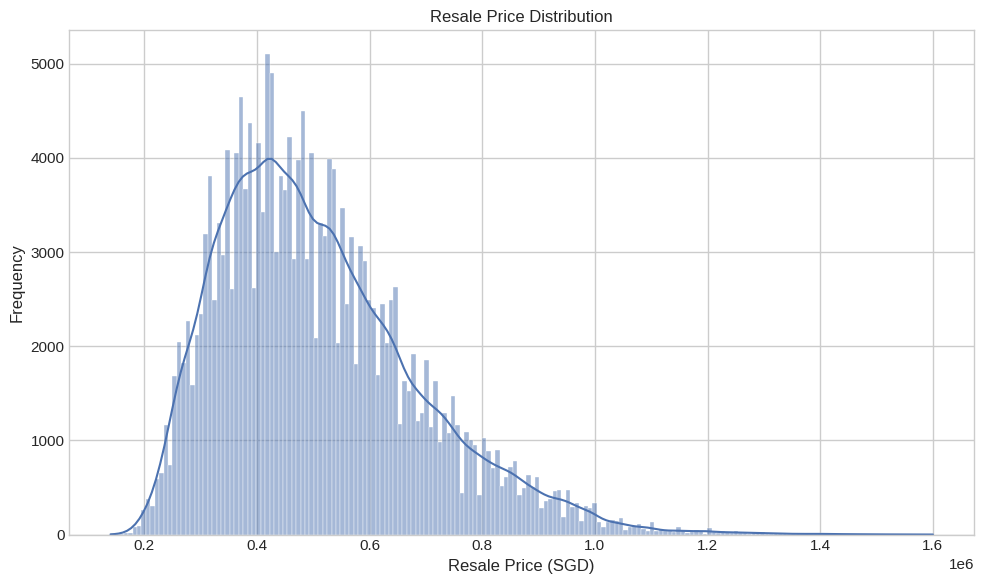

In [ ]:
# Visualize the price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['resale_price'], kde=True)
plt.title('Resale Price Distribution')
plt.xlabel('Resale Price (SGD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('resale_price_distribution.png')
plt.show()
plt.close()

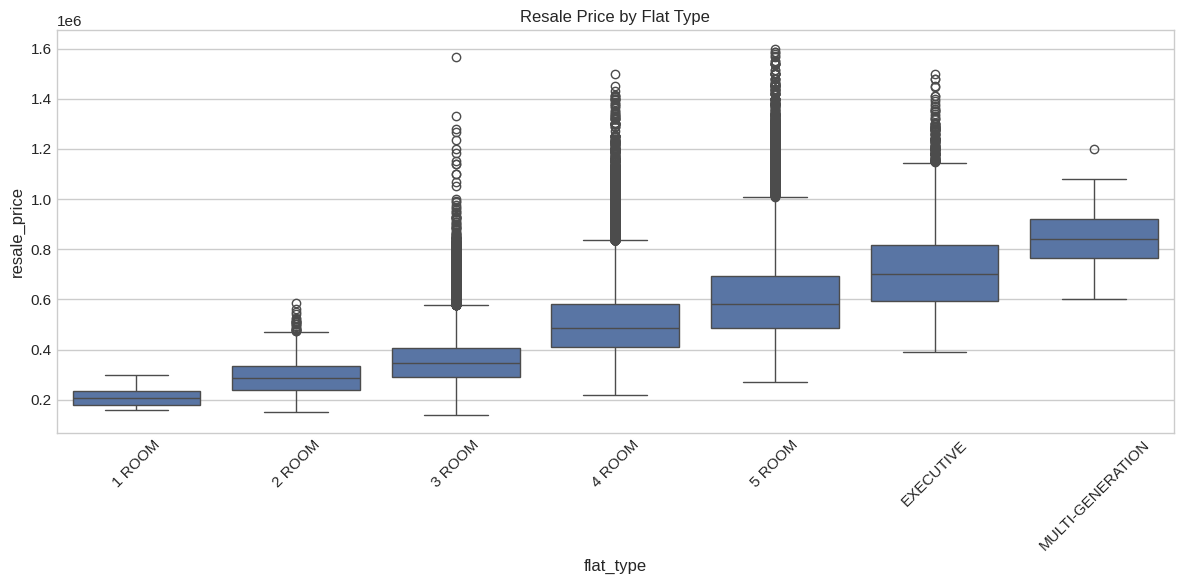

In [ ]:
# Visualize price by flat type
plt.figure(figsize=(12, 6))
sns.boxplot(x='flat_type', y='resale_price', data=df, order=df.groupby('flat_type')['resale_price'].median().sort_values().index)
plt.title('Resale Price by Flat Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('resale_price_by_flat_type.png')
plt.show()
plt.close()


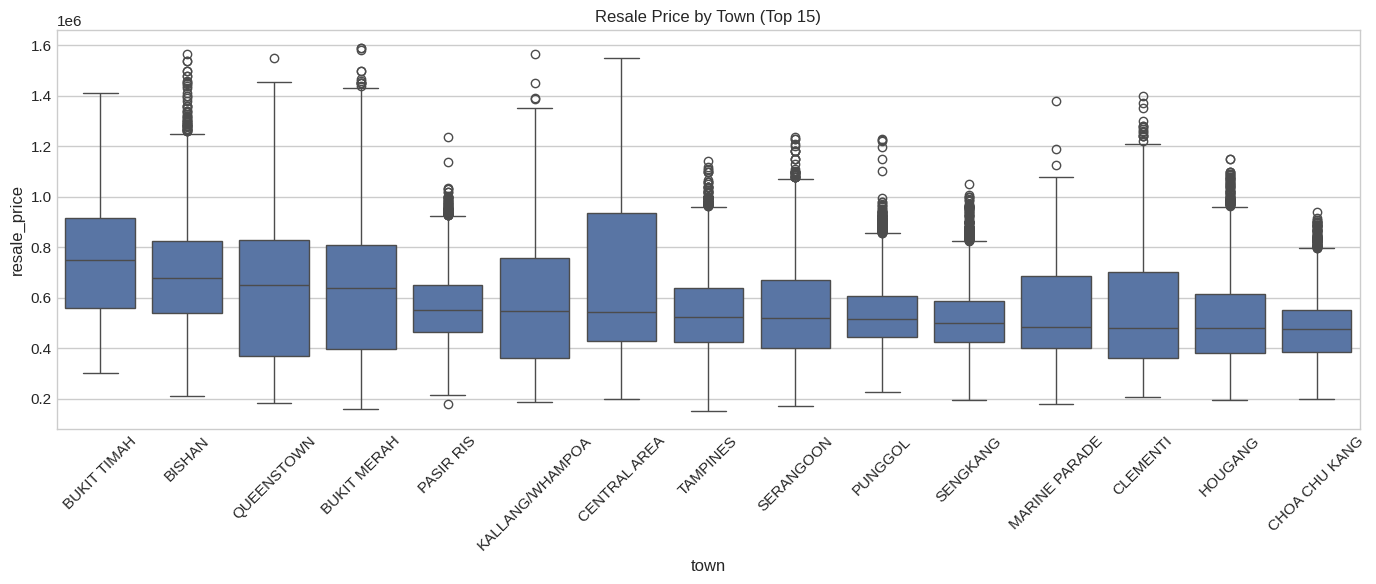

In [ ]:
# Visualize price by town (top 15 towns by median price)
top_towns = df.groupby('town')['resale_price'].median().sort_values(ascending=False).head(15).index
plt.figure(figsize=(14, 6))
sns.boxplot(x='town', y='resale_price', data=df[df['town'].isin(top_towns)], order=df[df['town'].isin(top_towns)].groupby('town')['resale_price'].median().sort_values(ascending=False).index)
plt.title('Resale Price by Town (Top 15)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('resale_price_by_town.png')
plt.show()
plt.close()

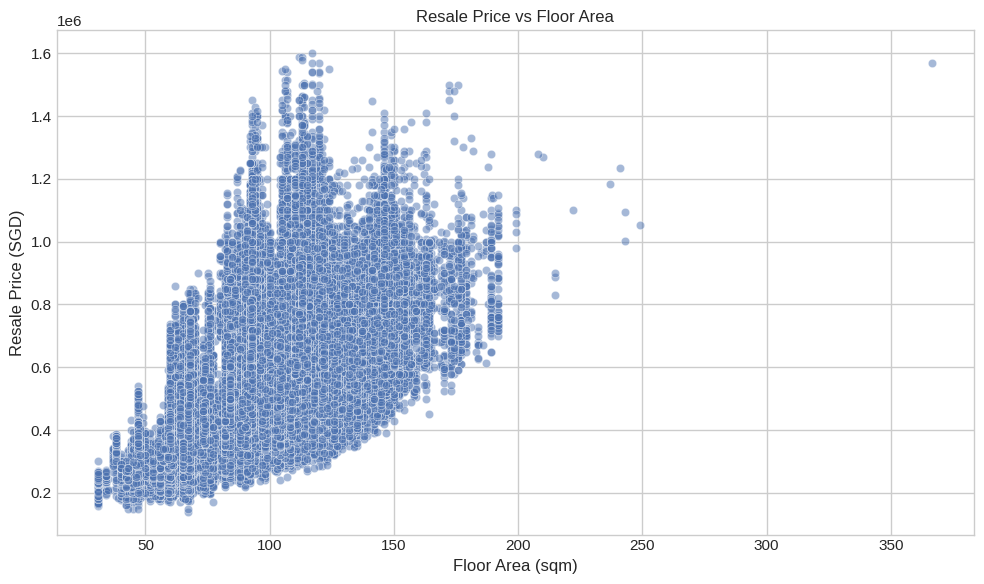

In [ ]:
# Relationship between floor area and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=df, alpha=0.5)
plt.title('Resale Price vs Floor Area')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.tight_layout()
plt.savefig('resale_price_vs_floor_area.png')
plt.show()
plt.close()


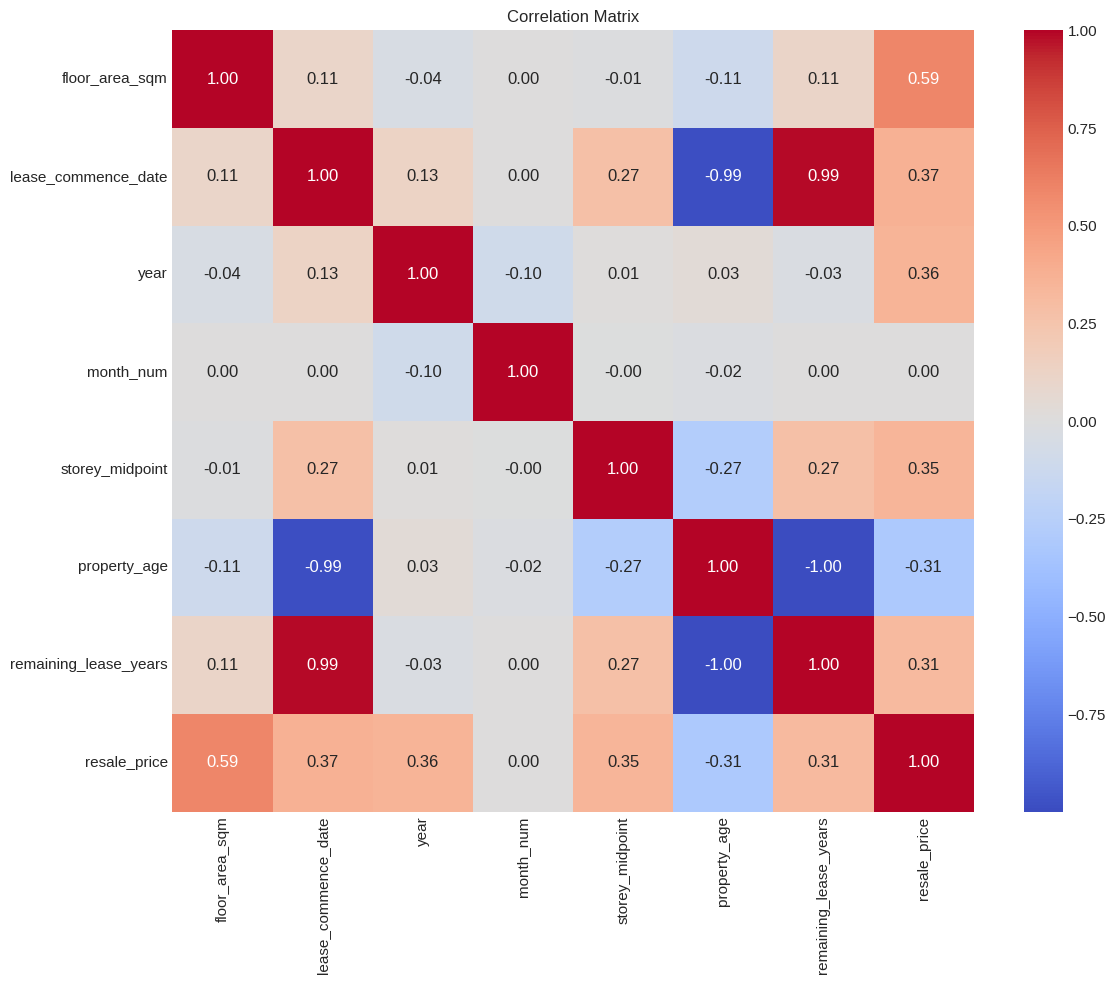

In [ ]:
# Calculate correlation between numerical features
numerical_cols = ['floor_area_sqm', 'lease_commence_date', 'year', 'month_num',
                 'storey_midpoint', 'property_age']
if 'remaining_lease_years' in df.columns:
    numerical_cols.append('remaining_lease_years')

plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_cols + ['resale_price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()


## 4. Property Price Prediction Model


In [ ]:
# Let's prepare the data for modeling
# We'll focus on key features that likely influence property prices
features = ['town', 'flat_type', 'storey_midpoint', 'floor_area_sqm',
           'flat_model', 'lease_commence_date', 'property_age']

if 'remaining_lease_years' in df.columns:
    features.append('remaining_lease_years')

X = df[features]
y = df['resale_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (160669, 8)
Testing set shape: (40168, 8)


In [ ]:
# Preprocessing: handle categorical and numerical features
categorical_features = ['town', 'flat_type', 'flat_model']
numerical_features = [col for col in features if col not in categorical_features]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# 4.1 Linear Regression (Baseline)

In [ ]:
# 4.1 Linear Regression (Baseline)
lin_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [ ]:
# Train the model
lin_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['storey_midpoint',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'property_age',
                                                   'remaining_lease_years']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['town', 'flat_type',
                                                   'flat_model'])])),
                ('regressor', LinearRegression())])

In [ ]:
# Make predictions
lin_reg_preds = lin_reg_pipeline.predict(X_test)


In [ ]:
# Evaluate the model
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_preds))
lin_reg_mae = mean_absolute_error(y_test, lin_reg_preds)
lin_reg_r2 = r2_score(y_test, lin_reg_preds)

print("\nLinear Regression Results (Baseline):")
print(f"RMSE: ${lin_reg_rmse:.2f}")
print(f"MAE: ${lin_reg_mae:.2f}")
print(f"R²: {lin_reg_r2:.4f}")


Linear Regression Results (Baseline):
RMSE: $66110.17
MAE: $50913.62
R²: 0.8641


# 4.2 Random Forest Regressor

In [ ]:
# 4.2 Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [ ]:
# Train the model
#rf_pipeline.fit(X_train, y_train)

In [ ]:
# Make predictions
#rf_preds = rf_pipeline.predict(X_test)


In [ ]:
# Evaluate the model
# rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
# rf_mae = mean_absolute_error(y_test, rf_preds)
# rf_r2 = r2_score(y_test, rf_preds)

# print("\nRandom Forest Results:")
# print(f"RMSE: ${rf_rmse:.2f}")
# print(f"MAE: ${rf_mae:.2f}")
# print(f"R²: {rf_r2:.4f}")

# 4.3 XGBoost Regressor

In [ ]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])


In [ ]:
# Train the model
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['storey_midpoint',
                                                   'floor_area_sqm',
                                                   'lease_commence_date',
                                                   'property_age',
                                                   'remaining_lease_years']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['town', 'flat_type',
                                                   'flat_model'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Make predictions
xgb_preds = xgb_pipeline.predict(X_test)

In [ ]:
# Evaluate the model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_r2 = r2_score(y_test, xgb_preds)

print("\nXGBoost Results:")
print(f"RMSE: ${xgb_rmse:.2f}")
print(f"MAE: ${xgb_mae:.2f}")
print(f"R²: {xgb_r2:.4f}")


XGBoost Results:
RMSE: $53267.69
MAE: $39595.55
R²: 0.9118


# Compare the models


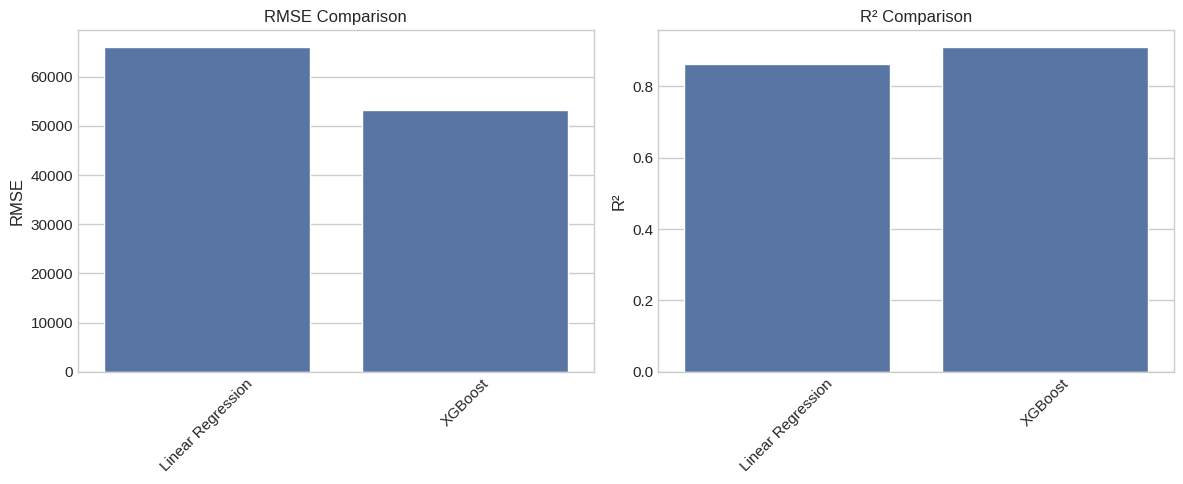

In [ ]:
models = ['Linear Regression', 'XGBoost']
rmse_scores = [lin_reg_rmse, xgb_rmse]
r2_scores = [lin_reg_r2, xgb_r2]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=rmse_scores)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=r2_scores)
plt.title('R² Comparison')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()
plt.close()

# Save the best model

In [ ]:
best_model = xgb_pipeline
with open('property_price_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## 5. Rental Income Estimation
